# Training a classifier on a real dataset.

## Task:

We need to train a classifier that determines the type of bicycle on a small dataset of bicycle photos from public sources.

Analyse the data, select the appropriate tools and metrics to address this challenge.

You are allowed to use pre-trained models from torchvision.models.
Write a report about the results.

## Data

In [ ]:
! wget http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip

In [ ]:
! unzip bt_dataset3.zip -d dataset

## Solution

In [ ]:
import os
import abc
import time
import typing
import random
import warnings

import PIL
import tqdm
import torch
import wandb
import numpy
import pandas
import torchvision
import sklearn.metrics
import matplotlib.pyplot as plt
import torch.utils.data as torchdata
from torchvision.transforms import v2 as transforms

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
def fix_random():
    return set_random_seed(RANDOM_STATE)
fix_random()

In [ ]:
wandb.login(anonymous = "allow")

### Analyze the dataset

#### Class distribution

In [ ]:
train_images = torchvision.datasets.ImageFolder("./dataset/train")
labels = numpy.array([ label for (image, label) in train_images ])
unique, counts = numpy.unique(labels, return_counts = True)
plt.bar(unique, counts)

# Save distribution for later use
class_counts = torch.tensor(counts)
print(class_counts)

Видно, что классы крайне несбалансированы, из-за чего в качестве целевой метрики accuracy будет иметь мало смысла. Воспользуемся средним значением F1-меры: эта метрика лучше показывает качество предсказаний при решении задачи классификации несбалансированного датасета.

#### Image size distribution

In [ ]:
def print_distribution(dataset):
    min_size = numpy.array([ min(image.size) for (image, label) in dataset ])
    unique, counts = numpy.unique(min_size, return_counts = True)
    mean = numpy.mean(min_size)
    std = numpy.std(min_size)
    plt.bar(unique, counts)
    plt.plot([ mean, mean ], [ 0, numpy.max(counts) ], color = 'red', linestyle = 'dashed', label = 'mean')
    plt.legend()
    print({
        'Mean': mean,
        'Std': std,
        'Min': numpy.min(unique),
        'Max': numpy.max(unique)
    })

In [ ]:
print_distribution(train_images)

Удалим очень маленькие и очень большие картинки из тестовой выборки. Они могут плохо влиять на процесс обучения

In [ ]:
idx = [ i for i in range(len(train_images)) if 224 / 4 < min(train_images[i][0].size) < 224 * 4 ]
print('Images before: {}'.format(len(train_images)))
train_images = torchdata.Subset(train_images, idx)
print('Images after: {}'.format(len(train_images)))
print_distribution(train_images)

Средний размер картинок примерно равен 220. Скорее всего, предобученные на ImageNet модели, релизованные в torchvision, достаточно хорошо подходят для решения поставленной задачи.

### Dataset

#### Raw dataset

In [ ]:
class MyDataset(torchdata.Dataset):
    def __init__(
            self,
            name: str,
            dataset: torchvision.datasets.ImageFolder,
            preload: bool = True,
            precalculate_transform: bool = True,
            transform: typing.Optional[transforms.Compose] = None
        ):
        self.name = name
        self.transform = None
        self.dataset = dataset
        self.precalculated_transform = None

        # The dataset is not that big, so we might want to load it into RAM beforehand
        if preload or precalculate_transform:
            if precalculate_transform:
                # We might also want to precalculate the transform
                self.precalculated_transform = transform
                self.transform = transform
                transform = None
            # If precalculate_transform is True, self.transform is set, and __getitem__ will apply the transforms
            self.images, self.targets = self.load_all("Preload {}".format(self.name))
        # If precalculate_transform is True, this will be None
        self.transform = transform

    def load_all(self, progress_bar: bool = False):
        images = [ ]
        targets = [ ]
        for record in (tqdm.tqdm(self, desc = progress_bar.ljust(25)) if progress_bar else self):
            images.append(record[0])
            targets.append(record[1])
        # If no transforms are applied, torch.stack(images) will fail
        try: return torch.stack(images), targets
        except: return images, targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if hasattr(self, 'images') and hasattr(self, 'targets'):
            # If the data has been preloaded, use it
            image, target = self.images[idx], self.targets[idx]
        else:
            # Access the source
            image, target = self.dataset[idx]
        # Apply the transform if needed
        if self.transform is not None:
            image = self.transform(image)
        return image, target
    
    def channel_stats(self):
        images, _ = self.load_all() # Get the dataset as two tensors
        # Calculate the metrics
        mean = torch.mean(images, dim = [0, 2, 3])
        std = torch.std(images, dim = [0, 2, 3])
        return mean, std

In [ ]:
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize(256),
    torchvision.transforms.v2.RandomCrop((224, 224)),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True)
])

dataset = MyDataset("train", train_images, transform = transform, preload = True, precalculate_transform = True)
mean, std = dataset.channel_stats()
print(mean, std)
del dataset

In [ ]:
fix_random()

transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize(256),
    torchvision.transforms.v2.RandomCrop((224, 224)),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    torchvision.transforms.v2.Normalize(mean, std)
])

test_images = torchvision.datasets.ImageFolder("./dataset/val")
test_set = MyDataset("val", test_images, transform = transform, preload = True, precalculate_transform = True)
train_set = MyDataset("train", train_images, transform = transform, preload = True, precalculate_transform = True)

# Denormalization
denormalize = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Normalize(mean = [ 0., 0., 0. ], std = 1 / std),
    torchvision.transforms.v2.Normalize(mean = -mean, std = [ 1., 1., 1. ])
])

# Display some samples from each dataset
def display_examples(dataset: torchdata.Dataset, row: int):
    train_loader = torchdata.DataLoader(dataset, batch_size = 10, shuffle = True)
    for i, (image, label) in enumerate(zip(*next(iter(train_loader)))):
        plt.subplot(3, 10, i + 10 * (row - 1) + 1)
        plt.axis('off')
        plt.title('{}'.format(label))
        plt.imshow((denormalize(image).permute(1, 2, 0).numpy() * 255).astype(numpy.uint8))

plt.rcParams["figure.figsize"] = (15, 5)
display_examples(train_set, 1)
display_examples(test_set, 2)

del train_set
del test_set

#### Dataset of features

In [ ]:
class FeaturesDataset(torchdata.StackDataset):
    def __init__(
            self,
            extractor_name: str,
            dataset: MyDataset,
            batch_size: int = 256,
            extractor_device: torch.device = device
        ):
        self.extractor_name = extractor_name
        self.name = 'Features for {} with {}'.format(dataset.name, extractor_name)

        # If it is already a dataset of features, return
        if isinstance(dataset, FeaturesDataset):
            return super().__init__(dataset)

        # https://github.com/pytorch/vision/issues/7744
        def get_state_dict(self, *args, **kwargs):
            kwargs.pop("check_hash")
            return torch.hub.load_state_dict_from_url(self.url, *args, **kwargs)
        torchvision.models._api.WeightsEnum.get_state_dict = get_state_dict

        # Load a pretrained model
        self.weights = torchvision.models.get_model_weights(extractor_name).DEFAULT
        self.extractor = torchvision.models.get_model(extractor_name, weights = self.weights)
        self.transform = self.weights.transforms()
        self.extractor_device = extractor_device

        # Remove last layer
        if hasattr(self.extractor, 'fc'): self.extractor.fc = torch.nn.Identity() # ResNet
        elif hasattr(self.extractor, 'classifier'): self.extractor.classifier = torch.nn.Identity() # All others
        
        save_transform = dataset.transform if hasattr(dataset, 'transform') else None
        dataset.transform = None
        assert isinstance(dataset[0][0], PIL.Image.Image) # Without transforms it should return raw images
        dataset.transform = self.transform # Use transforms for pretrained model

        targets = [ ]
        features = [ ]
        self.extractor.to(self.extractor_device).eval() # Enter evaluation mode
        loader = torchdata.DataLoader(dataset, batch_size = batch_size) # Create a dataloader
        for images_batch, targets_batch in tqdm.tqdm(loader, desc = self.name.ljust(25)):
            with torch.no_grad():
                # Calculate features
                features_batch = self.extractor(images_batch.to(self.extractor_device))
                if features_batch.dim() == 4:
                    # Maybe apply adaptive average pooling if it is not built into the model
                    features_batch = torch.nn.functional.adaptive_avg_pool2d(features_batch, 1)
                # Flatten the output
                features.append(features_batch.detach().cpu().flatten(start_dim = 1))
                targets.append(targets_batch)

        # Free up the GPU
        self.extractor = self.extractor.to('cpu')
        if self.extractor_device.type == 'cuda': torch.cuda.empty_cache()
        elif self.extractor_device.type == 'mps': torch.mps.empty_cache()

        dataset.transform = save_transform # Restore transforms of the base dataset
        super().__init__(torch.cat(features), torch.cat(targets)) # Initialize StackDataset

In [ ]:
class FeaturesCatDataset(torchdata.StackDataset):
    def __init__(self, *datasets: typing.List[FeaturesDataset]):
        self.name = datasets[0].name
        self.extractors = [ ]
        for dataset in datasets:
            assert len(dataset) == len(datasets[0])
            self.extractors.append(dataset.extractor_name)
        self.name = 'Features for {} with {}'.format(self.name, ', '.join(self.extractors))

        targets = [ ]
        features = [ ]
        for i in range(len(datasets[0])):
            item_features = [ ]
            item_target = datasets[0][i][1]
            for dataset in datasets:
                assert dataset[i][1] == item_target
                item_features.append(dataset[i][0])
            targets.append(item_target)
            features.append(torch.cat(item_features))

        super().__init__(torch.stack(features), torch.tensor(targets)) # Initialize StackDataset

### Classifier

In [ ]:
class BaseClassifier(abc.ABC):
    @abc.abstractmethod
    def fit(self, train_set: torchdata.Dataset, val_set: torchdata.Dataset):
        raise NotImplementedError

    @abc.abstractmethod
    def predict(self, images: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError
    
    def calc_metrics(self, dataset: torchdata.Dataset, report: bool = False) -> dict:
        num_classes = self.output_shape[0] if hasattr(self, 'output_shape') else len(dataset.classes)
        batch_size = self.batch_size if hasattr(self, 'batch_size') else 512
        classes = torch.arange(num_classes)

        all_labels = torch.tensor([])
        all_predictions = torch.tensor([])
        all_scores = torch.empty((0, num_classes))
        loader = torchdata.DataLoader(dataset, batch_size = batch_size, shuffle = False)
        for images, labels in loader:
            predictions, scores = self.predict(images)
            all_labels = torch.cat([ all_labels, labels ])
            all_scores = torch.cat([ all_scores, scores.detach().cpu() ])
            all_predictions = torch.cat([ all_predictions, predictions.detach().cpu() ])

        if report:
            print(sklearn.metrics.classification_report(all_labels, all_predictions, labels = classes))

        return {
            'Accuracy':       sklearn.metrics.accuracy_score      (all_labels, all_predictions),
            'TOP-2 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 2, labels = classes),
            'TOP-3 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 3, labels = classes),
            'TOP-4 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 4, labels = classes),
            'AUC-ROC':        sklearn.metrics.roc_auc_score       (all_labels, all_scores, multi_class = 'ovo'),
            'Precision':      sklearn.metrics.precision_score     (all_labels, all_predictions, average = 'macro', zero_division = 0),
            'Recall':         sklearn.metrics.recall_score        (all_labels, all_predictions, average = 'macro', zero_division = 0),
            'F1-score':       sklearn.metrics.f1_score            (all_labels, all_predictions, average = 'macro', zero_division = 0)
        }

In [ ]:
class Classifier(BaseClassifier):
    results = [ ]

    def __init__(
            self,
            name: str,
            model: torch.nn.Module,
            batch_size: int = 256,
            learning_rate: int = 1e-3,
            device: torch.device = device,
            class_weights: torch.Tensor = None,
            optimizer: typing.Optional[torch.optim.Optimizer] = None,
            scheduler: typing.Optional[torch.optim.lr_scheduler.LRScheduler] = None,
        ):
        self.name = name
        self.device = device
        self.input_shape = None
        self.output_shape = None
        self.scheduler = scheduler
        self.batch_size = batch_size
        self.model = model.to(self.device)
        self.best_metrics = { 'F1-score': 0 }
        self.optimizer = optimizer or torch.optim.AdamW(self.model.parameters(), lr = learning_rate)
        self.loss = torch.nn.CrossEntropyLoss(weight = class_weights.to(self.device) if class_weights is not None else None)


    def train(self, images: torch.Tensor, labels: torch.Tensor) -> float:
        self.model.train() # Enter train mode
        self.optimizer.zero_grad() # Zero gradients
        output = self.model(images.to(self.device)) # Get predictions
        loss = self.loss(output, labels.to(self.device)) # Calculate loss
        loss.backward() # Calculate gradients
        self.optimizer.step() # Update weights
        return loss.item()

    def train_epoch(self, loader: torchdata.DataLoader) -> float:
        sum_loss = 0
        for images, labels in loader:
            sum_loss += self.train(images, labels) # Train one batch
        if self.scheduler is not None:
            self.scheduler.step() # Change learning rate
        return sum_loss / len(loader) # Return average loss to avoid random-dependent graph
       
    def fit(self, train_set: torchdata.Dataset, val_set: torchdata.Dataset, n_epochs: int = 25, silent: bool = False):
        if self.input_shape is None or self.output_shape is None:
            self.predict(train_set[0][0].unsqueeze(0)) # Initialize lazy layers and in/out shapes
        loader = torchdata.DataLoader(train_set, batch_size = self.batch_size, shuffle = True)

        wandb_settings = { "silent": True, "disable_git": True } if silent else None
        wandb.init(project = "CV-HW-6", name = self.name, anonymous = "allow", settings = wandb_settings)
        wandb.watch(self.model, log = "all")

        for epoch in tqdm.trange(n_epochs, desc = "Fit {}".format(self.name).ljust(25)):
            # Train
            train_start = time.perf_counter()
            loss = self.train_epoch(loader)
            train_time = time.perf_counter() - train_start

            # Validate
            val_start = time.perf_counter()
            metrics = self.calc_metrics(val_set)
            val_time = time.perf_counter() - val_start
            
            # Upload metrics
            metrics['Learning rate'] = self.optimizer.param_groups[0]['lr']
            metrics['Validation time'] = val_time
            metrics['Train time'] = train_time
            metrics['Loss'] = loss
            wandb.log(metrics)
            metrics['Epoch'] = epoch + 1

            if metrics['F1-score'] > self.best_metrics['F1-score']:
                self.best_metrics = metrics
                state = { **metrics, 'Model': self.model.state_dict(), 'Optimizer': self.optimizer.state_dict() }
                torch.save(state, "models/{}.pt".format(self.name))

        # Finish the run
        wandb.finish(quiet = True)

        # Store best metrics
        Classifier.results.append({ 'Name': self.name, **self.best_metrics })
        return self
    

    def predict(self, images: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        if self.input_shape is None:
            self.input_shape = images[0].shape # Lazily initialize input shape

        self.model.eval() # Enter evaluation mode
        with torch.no_grad():
            outputs = self.model(images.to(self.device)) # Get outputs
            scores = torch.softmax(outputs, dim = 1) # Make probabilities
            predictions = torch.argmax(scores, dim = 1) # Calculate predictions

        if self.output_shape is None:
            self.output_shape = scores[0].shape # Lazily initialize output shape
        return predictions, scores
    

    def summary(self):
        display(pandas.DataFrame(Classifier.results)) # Print run history

### Try pretrained models

Для начала попробуем извлечь признаки из картинок с помощью предобученных моделей, и обучить классификатор на полученных признаках. Попробуем различные модели, реализованные в torchvision.

In [ ]:
# Make datasets without transforms to calculate image features
train_set = MyDataset("train", train_images, preload = True, precalculate_transform = True, transform = None)
test_set = MyDataset("test", test_images, preload = True, precalculate_transform = True, transform = None)

In [ ]:
models = [
    ("alexnet", 1024),
    ("convnext_large", 64),
    ("densenet201", 256),
    ("efficientnet_b7", 16),
    ("efficientnet_v2_l", 32),
    ("googlenet", 512),
    ("inception_v3", 256),
    ("maxvit_t", 64),
    ("mnasnet1_3", 256),
    ("mobilenet_v2", 256),
    ("mobilenet_v3_large", 512),
    ("regnet_x_32gf", 32),
    ("resnet152", 256),
    ("resnext101_64x4d", 128),
    ("shufflenet_v2_x2_0", 512),
    ("squeezenet1_1", 256),
    ("swin_v2_b", 64),
    ("vgg19_bn", 64),
    ("vit_b_16", 64),
    ("wide_resnet101_2", 128)
]
for index, (extractor_name, batch_size) in enumerate(models):
    print("\033[95m{}\033[0m (\033[92m{}\033[0m/\033[94m{}\033[0m):".format(extractor_name.upper(), index + 1, len(models)))

    fix_random()
    warnings.filterwarnings("ignore")
    train_features = FeaturesDataset(extractor_name, train_set, batch_size = batch_size)
    test_features = FeaturesDataset(extractor_name, test_set, batch_size = batch_size)

    model = torch.nn.Sequential(torch.nn.LazyLinear(128), torch.nn.GELU(), torch.nn.Linear(128, 5))
    classifier = Classifier(extractor_name, model, learning_rate = 1e-5, batch_size = 256, class_weights = 1 / class_counts)
    classifier.fit(train_features, test_features, n_epochs = 1000, silent = True)

In [ ]:
display(pandas.DataFrame(Classifier.results))

![Alternative Text][1700908604973]

[1700908604973]: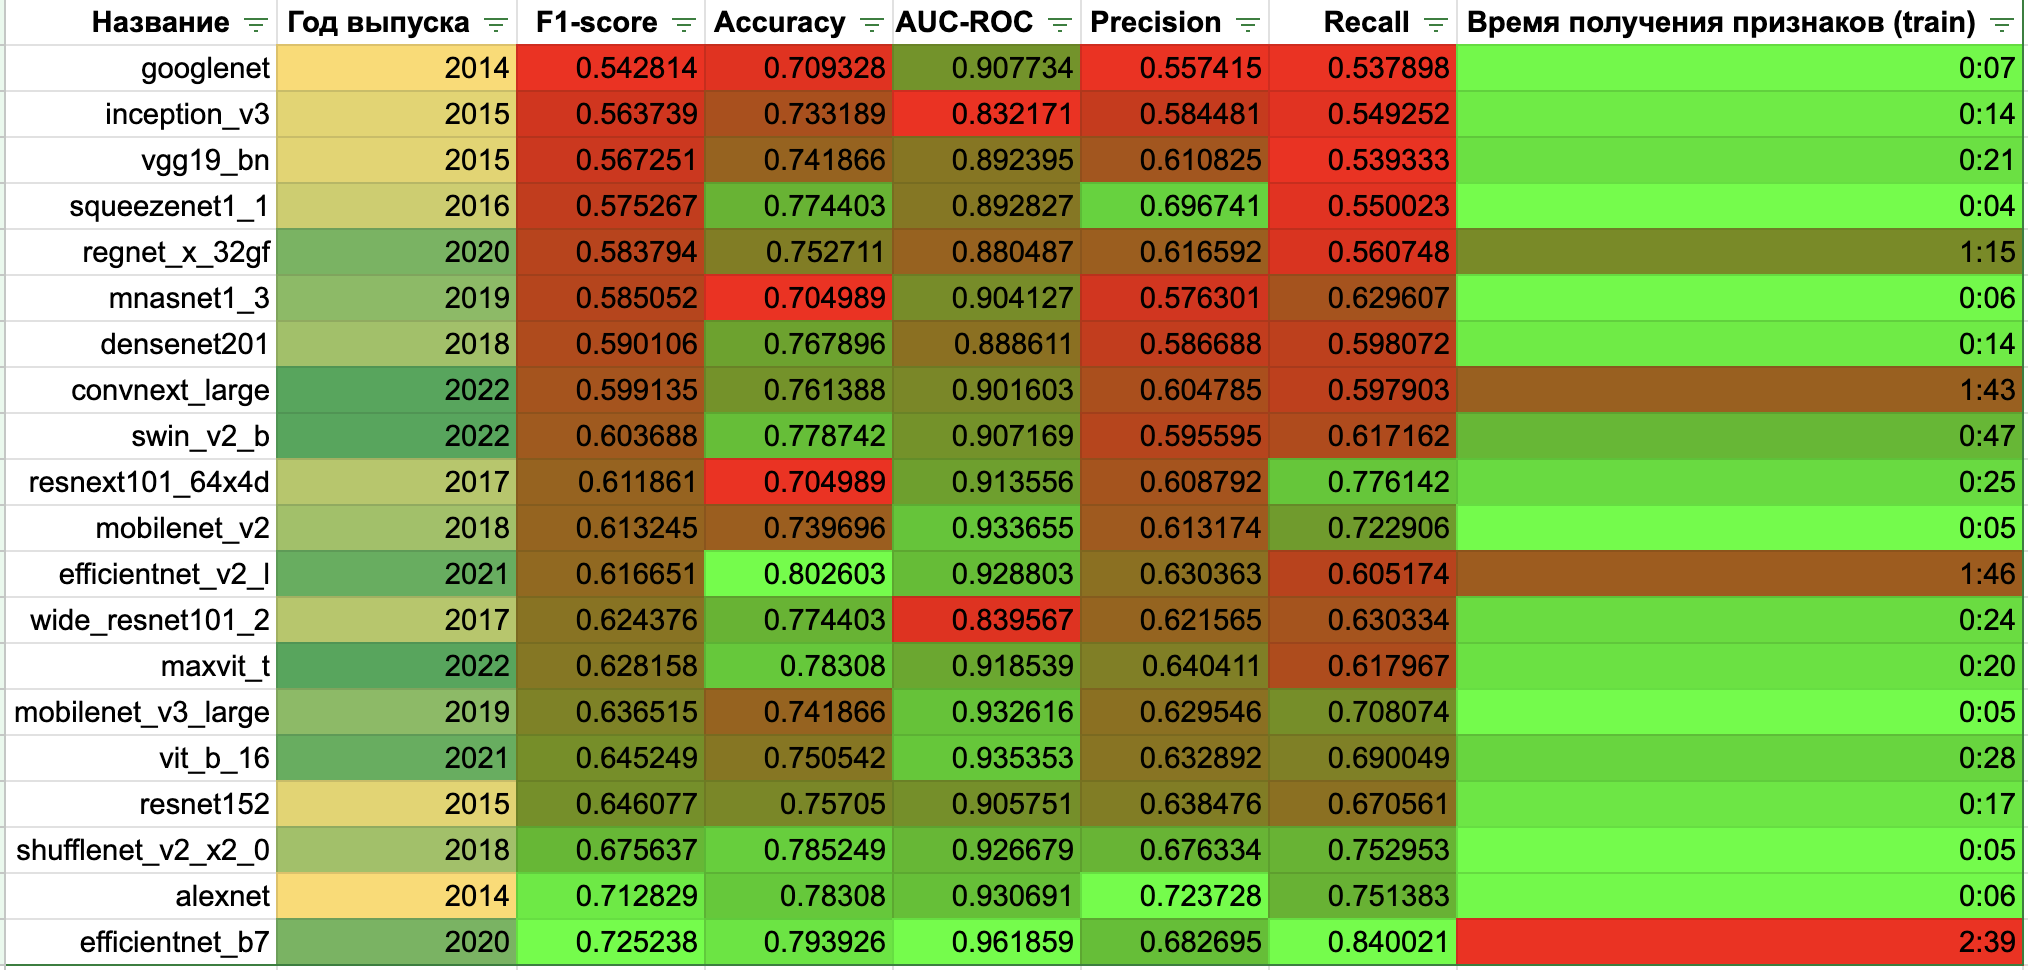

Видно, что на признаках, извлеченных моделями AlexNet и EfficientNetB7 удается достичь наилучшего качество. \
Также заметим, что классификатор над AlexNet показал лучший Precision, а над EfficientNet - наилучший Recall. Возможно, если обучить классификатор на признаках, извлеченных этими моделями, одновременно, удастся повысить качество

### Alexnet + EfficientNetB7

In [ ]:
Classifier.results = [ ]

alexnet_train_features = FeaturesDataset("alexnet", train_set, batch_size = 1024)
alexnet_test_features = FeaturesDataset("alexnet", test_set, batch_size = 1024)

effnet_train_features = FeaturesDataset("efficientnet_b7", train_set, batch_size = 16)
effnet_test_features = FeaturesDataset("efficientnet_b7", test_set, batch_size = 16)

print('AlexNet: {}'.format(alexnet_train_features[0][0].shape))
print('EfficientNet: {}'.format(effnet_train_features[0][0].shape))

# Concatenate features
train_features = FeaturesCatDataset(alexnet_train_features, effnet_train_features)
test_features = FeaturesCatDataset(alexnet_test_features, effnet_test_features)
print('AlexNet + EfficientNet: {}'.format(train_features[0][0].shape))

In [ ]:
fix_random()
model = torch.nn.Sequential(torch.nn.LazyLinear(128), torch.nn.GELU(), torch.nn.Linear(128, 5))
classifier = Classifier('AlexNet + EfficientNet', model, learning_rate = 1e-5, batch_size = 256, class_weights = 1 / class_counts)
classifier.fit(train_features, test_features, n_epochs = 1000, silent = True)
classifier.summary()

Действительно, стало немного лучше. Precision немного увеличился, хотя Recall уменьшился. \
Заметим, что ALexNet и EfficientNet извлекают разное количество признаков. Скорее всего, не очень хорошо их просто "склеивать". Попробуем обучить классификаторы отдельно для признаков, извлеченных каждой моделью, а затем объединить результаты в итоговый полносвязный слой.

In [ ]:
class MyModule(torch.nn.Module):
    def __init__(self, alexnet_feature_map: torch.nn.Module, effnet_feature_map: torch.nn.Module, classifier: torch.nn.Module):
        super().__init__()
        self.classifier = classifier
        self.effnet_feature_map = effnet_feature_map
        self.alexnet_feature_map = alexnet_feature_map
    
    def forward(self, images):
        effnet = self.effnet_feature_map(images[:, 9216:])
        alexnet = self.alexnet_feature_map(images[:, :9216])
        return self.classifier(torch.cat([ alexnet, effnet ], dim = 1))

class FirstIdea(MyModule):
    def __init__(self):
        super().__init__(
            alexnet_feature_map = torch.nn.Sequential(torch.nn.LazyLinear(128)),
            effnet_feature_map = torch.nn.Sequential(torch.nn.LazyLinear(128)),
            classifier = torch.nn.Sequential(torch.nn.GELU(), torch.nn.Linear(256, 5))
        )
    
fix_random()
classifier = Classifier("FirstIdea", FirstIdea(), learning_rate = 1e-5, batch_size = 256, class_weights = 1 / class_counts)
classifier.fit(train_features, test_features, n_epochs = 1000, silent = True)
classifier.summary()

Явно наблюдается переобучение. Попробуем добавить Dropout. Кажется, логично это сделать перед полносвязным слоем, который получает на вход признаки, извлеченные AlexNet, так как их гораздо больше, чем признаков, извлеченных EfficientNet.

In [ ]:
class SecondIdea(MyModule):
    def __init__(self):
        super().__init__(
            alexnet_feature_map = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.LazyLinear(128)),
            effnet_feature_map = torch.nn.Sequential(torch.nn.LazyLinear(128)),
            classifier = torch.nn.Sequential(torch.nn.GELU(), torch.nn.Linear(256, 5))
        )
    
fix_random()
classifier = Classifier("SecondIdea", SecondIdea(), learning_rate = 1e-5, batch_size = 256, class_weights = 1 / class_counts)
classifier.fit(train_features, test_features, n_epochs = 1000, silent = True)
classifier.summary()

Стало лучше, но на большом количестве шаг обучения явно слишком большой. Попробуй добавить Scheduler, который будет уменьшать шаг обучения, если значение целевой метрики начинает сильно "прыгать"

In [ ]:
def lr_scheduler_lambda(iteration):
    if iteration < 10:
        return 10
    if iteration < 100:
        return 2
    if iteration < 200:
        return 1
    if iteration < 400:
        return 0.5
    if iteration < 750:
        return 0.25
    return 0.1


fix_random()
model = SecondIdea().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_scheduler_lambda)
classifier = Classifier("Scheduler - 3", model, optimizer = optimizer, scheduler = scheduler, learning_rate = 1e-5, batch_size = 256, class_weights = 1 / class_counts)
classifier.fit(train_features, test_features, n_epochs = 1000, silent = True)
classifier.summary()

Однозначно стало лучше. Попробуем теперь дообучить не только последний слой, но и сами AlexNet и EfficientNet. Небольшого количества эпох должно быть достаточно. При этом приходится использовать очень маленький размер пакета, чтобы вычисления могли производится на видеокарте. 

### Train full

In [ ]:
transform = torchvision.models.get_model_weights("efficientnet_b0").DEFAULT.transforms()

train_transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.RandAugment(),
    transform
])

# Remove last layer

train_set = MysteriousDataset(train = True, preload = False, precalculate_transform = False, transform = train_transform)
test_set = MysteriousDataset(train = False, preload = True, precalculate_transform = True, transform = transform)

In [ ]:
fix_random()

# Denormalization
denormalize = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Normalize(mean = [ 0., 0., 0. ], std = 1 / std),
    torchvision.transforms.v2.Normalize(mean = -mean, std = [ 1., 1., 1. ])
])

# Display some samples from each dataset
def display_examples(dataset: torchdata.Dataset, row: int):
    train_loader = torchdata.DataLoader(dataset, batch_size = 10, shuffle = True)
    for i, (image, label) in enumerate(zip(*next(iter(train_loader)))):
        plt.subplot(3, 10, i + 10 * (row - 1) + 1)
        plt.axis('off')
        plt.title('{}'.format(label))
        plt.imshow((denormalize(image).permute(1, 2, 0).numpy() * 255).astype(numpy.uint8))

plt.rcParams["figure.figsize"] = (15, 5)
display_examples(train_set, 1)
display_examples(test_set, 2)

In [ ]:
class MyNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.maxvit_weights = torchvision.models.get_model_weights("maxvit_t").DEFAULT
        self.maxvit = torchvision.models.get_model("maxvit_t", weights = self.maxvit_weights)
        if hasattr(self.maxvit, 'fc'): self.maxvit.fc = torch.nn.Identity() # ResNet
        elif hasattr(self.maxvit, 'classifier'): self.maxvit.classifier = torch.nn.Identity() # All others
        self.maxvit_feature_map = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.Linear(25088, 256), torch.nn.BatchNorm1d(256), torch.nn.GELU())

        self.effnet_weights = torchvision.models.get_model_weights("efficientnet_b0").DEFAULT
        self.effnet = torchvision.models.get_model("efficientnet_b0", weights = self.effnet_weights)
        if hasattr(self.effnet, 'fc'): self.maxvit.fc = torch.nn.Identity() # ResNet
        elif hasattr(self.effnet, 'classifier'): self.maxvit.classifier = torch.nn.Identity() # All others
        self.effnet_feature_map = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.Linear(1000, 256), torch.nn.BatchNorm1d(256), torch.nn.GELU())
        
        self.classifier = torch.nn.Sequential(torch.nn.Linear(512, 5))

    def forward(self, images):
        maxvit_features = self.maxvit_feature_map(self.maxvit(images).flatten(start_dim = 1))
        effnet_features = self.effnet_feature_map(self.effnet(images).flatten(start_dim = 1))
        return self.classifier(torch.cat([ maxvit_features, effnet_features ], dim = 1))
    
MyNet()(torch.rand((4, 3, 224, 224))).shape

In [ ]:
fix_random()
model = MyNet()
classifier = Classifier("Train full", model, learning_rate = 3e-5, batch_size = 12).fit(train_set, test_set, silent = True)
classifier.calc_metrics(test_set)

In [ ]:
classifier.summary()

# Report
...